<a href="https://colab.research.google.com/github/bibhs0401/transformer-content-recommendation/blob/main/Automated_Content_Recommendation_with_Transformer_Embeddings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Automated Content Recommendation with Transformer Embeddings

Automated Content Recommendation with Transformer Embeddings is a modern approach to building personalized recommendation systems by leveraging the power of transformer models (like BERT, DistilBERT, or sentence transformers) to create dense vector representations (embeddings) of content.

These embeddings capture the semantic meaning of content (e.g., articles, products, reviews, or user queries), making it possible to match users with content that's contextually and semantically relevant.

By using word embeddings, we can transform text into numerical representations that capture semantic meaning, enabling more efficient clustering and analysis of the data.

This notebook contains different steps, including generating embeddings with pre-trained transformer models, reducing the dimensionality of these embeddings(using techniques such as PCA and UMAP, to high-dimensional text embeddings.), implementing various clustering algorithms, including K-Means, FAISS, and Agglomerative Clustering, to categorize text data, and evaluate and compare the performance of different clustering methods using metrics like silhouette score.

In [ ]:
#installing required libraries
%%capture
!pip install pandas torch transformers scikit-learn faiss-cpu matplotlib umap-learn
!pip install --dry-run numba numpy

In [ ]:
#importing required libraries
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModel
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import normalize, StandardScaler
from sklearn.decomposition import PCA
from scipy.stats import spearmanr
import faiss
import umap

import matplotlib.pyplot as plt
import numpy as np

1. Data Loading and initial exploration

In [ ]:
#dataset from IBM Skills Network
labs = pd.read_csv('https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/AKmsNHd_-KnDvXWzNhaSrw/Labs.csv')
labs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4726 entries, 0 to 4725
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 4726 non-null   int64  
 1   name               4726 non-null   object 
 2   short_description  4110 non-null   object 
 3   status             4726 non-null   object 
 4   rating             4726 non-null   float64
 5   tag                4726 non-null   object 
 6   created_at         4726 non-null   object 
 7   language           4726 non-null   object 
dtypes: float64(1), int64(1), object(6)
memory usage: 295.5+ KB


In [ ]:
labs.head()

,id,name,short_description,status,rating,tag,created_at,language
0,1577,eugene-tst-img-lib,NaN,Draft,0.0,JavaScript,2022-06-17 14:18:20 UTC,English
1,1466,Основи аналізу даних в банківській справі,Мета цієї лабораторної роботи – освоїти попере...,Published,4.9,Programming,2022-05-31 04:36:24 UTC,Ukrainian
2,868,Performing Database Operations in the Cloudant...,"In this guided project, you will launch IBM Cl...",Published,3.7,Data Science,2021-11-18 01:54:57 UTC,English
3,868,Performing Database Operations in the Cloudant...,"In this guided project, you will launch IBM Cl...",Published,3.7,Machine Learning,2021-11-18 01:54:57 UTC,English
4,868,Performing Database Operations in the Cloudant...,"In this guided project, you will launch IBM Cl...",Published,3.7,Unsupervised,2021-11-18 01:54:57 UTC,English


Select labs where status is published and language is English

In [ ]:
# select labs where status is published and language is English

selected_labs = labs[(labs['status'] == 'Published') & (labs['language'] =='English')]
selected_labs.head()

,id,name,short_description,status,rating,tag,created_at,language
2,868,Performing Database Operations in the Cloudant...,"In this guided project, you will launch IBM Cl...",Published,3.7,Data Science,2021-11-18 01:54:57 UTC,English
3,868,Performing Database Operations in the Cloudant...,"In this guided project, you will launch IBM Cl...",Published,3.7,Machine Learning,2021-11-18 01:54:57 UTC,English
4,868,Performing Database Operations in the Cloudant...,"In this guided project, you will launch IBM Cl...",Published,3.7,Unsupervised,2021-11-18 01:54:57 UTC,English
5,868,Performing Database Operations in the Cloudant...,"In this guided project, you will launch IBM Cl...",Published,3.7,Clustering,2021-11-18 01:54:57 UTC,English
10,998,Retail: Data Preparation and Basic Statistica...,"This lab is dedicated to downloading, preparin...",Published,5.0,Machine Learning,2021-12-27 07:42:45 UTC,English


In [ ]:
# select labs where status is published and language is English

selected_labs = labs[(labs['status'] == 'Published') & (labs['language'] =='English')]
selected_labs.head()

,id,name,short_description,status,rating,tag,created_at,language
2,868,Performing Database Operations in the Cloudant...,"In this guided project, you will launch IBM Cl...",Published,3.7,Data Science,2021-11-18 01:54:57 UTC,English
3,868,Performing Database Operations in the Cloudant...,"In this guided project, you will launch IBM Cl...",Published,3.7,Machine Learning,2021-11-18 01:54:57 UTC,English
4,868,Performing Database Operations in the Cloudant...,"In this guided project, you will launch IBM Cl...",Published,3.7,Unsupervised,2021-11-18 01:54:57 UTC,English
5,868,Performing Database Operations in the Cloudant...,"In this guided project, you will launch IBM Cl...",Published,3.7,Clustering,2021-11-18 01:54:57 UTC,English
10,998,Retail: Data Preparation and Basic Statistica...,"This lab is dedicated to downloading, preparin...",Published,5.0,Machine Learning,2021-12-27 07:42:45 UTC,English


In [ ]:
# concatenate short_description and title into a single column

selected_labs['description'] = selected_labs['name'] + ' ' + selected_labs['short_description']
selected_labs.head()

/tmp/ipython-input-3025171542.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_labs['description'] = selected_labs['name'] + ' ' + selected_labs['short_description']


,id,name,short_description,status,rating,tag,created_at,language,description
2,868,Performing Database Operations in the Cloudant...,"In this guided project, you will launch IBM Cl...",Published,3.7,Data Science,2021-11-18 01:54:57 UTC,English,Performing Database Operations in the Cloudant...
3,868,Performing Database Operations in the Cloudant...,"In this guided project, you will launch IBM Cl...",Published,3.7,Machine Learning,2021-11-18 01:54:57 UTC,English,Performing Database Operations in the Cloudant...
4,868,Performing Database Operations in the Cloudant...,"In this guided project, you will launch IBM Cl...",Published,3.7,Unsupervised,2021-11-18 01:54:57 UTC,English,Performing Database Operations in the Cloudant...
5,868,Performing Database Operations in the Cloudant...,"In this guided project, you will launch IBM Cl...",Published,3.7,Clustering,2021-11-18 01:54:57 UTC,English,Performing Database Operations in the Cloudant...
10,998,Retail: Data Preparation and Basic Statistica...,"This lab is dedicated to downloading, preparin...",Published,5.0,Machine Learning,2021-12-27 07:42:45 UTC,English,Retail: Data Preparation and Basic Statistica...


In [ ]:
# select unique id,description
unique_labs = selected_labs[['id', 'description']].drop_duplicates()
unique_labs.head()


,id,description
2,868,Performing Database Operations in the Cloudant...
10,998,Retail: Data Preparation and Basic Statistica...
11,1014,Market Basket Analysis Market basket analysis ...
13,678,Client behavior classification in Banking The ...
16,1417,Market Basket Analysis for Marketing This lab ...


In [ ]:
descriptions = unique_labs['description'].tolist()

#check statistics about length of text in descprition column
max_length = max(len(str(desc)) for desc in descriptions)
min_length = min(len(str(desc)) for desc in descriptions)
avg_length = sum(len(str(desc)) for desc in descriptions) / len(descriptions)

print(f"Maximum length: {max_length}")
print(f"Minimum length: {min_length}")
print(f"Average length: {avg_length}")


Maximum length: 658
Minimum length: 3
Average length: 371.2625


2. Generate text embeddings

We are going to use a pre-trained transformer model to generate text embeddings for each description.

This is going to help in clustering similar descriptions together.

We need to create a transformer model as well as its associated tokenizer.

The tokenizer will take of breaking the input text (content descriptions) into separate tokens and convert tokens to token IDs.

The Transformer model is then used to convert token IDs to embedding vectors.


In [ ]:
Model = 'MiniLM'
# Choose a transformer model; 'bert-base-uncased' is a good starting point
model_name = 'bert-base-uncased' if Model=='BERT' else 'roberta-base' if Model=='RoBERTa' else 'sentence-transformers/all-MiniLM-L6-v2'
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

# Move model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
model.eval()  # Set model to evaluation mode

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 384, padding_idx=0)
    (position_embeddings): Embedding(512, 384)
    (token_type_embeddings): Embedding(2, 384)
    (LayerNorm): LayerNorm((384,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-5): 6 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=384, out_features=384, bias=True)
            (key): Linear(in_features=384, out_features=384, bias=True)
            (value): Linear(in_features=384, out_features=384, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=384, out_features=384, bias=True)
            (LayerNorm): LayerNorm((384,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)


#Aggregating embeddings

There are two approaches to convert each description to a vector:

Extracting the embedding vector of the [CLS] token. Classification token ([CLS]) is a special token used in Transformer architecture. It is a token that represents the entire input sequence or sentence and is placed at the beginning of the input.
Averaging all token embeddings in a sequence (description).


In [ ]:
def CLS_embeddings(text_list, tokenizer, model, device, batch_size=1):
    embeddings = []
    with torch.no_grad():
        for i in range(0, len(text_list), batch_size):
            batch_text = text_list[i:i+batch_size]
            # Ensure all elements in batch_text are strings
            batch_text = [str(text) for text in batch_text]  # Convert to strings
            encoded_input = tokenizer(batch_text, padding=True, truncation=True, return_tensors='pt', max_length=512)
            input_ids = encoded_input['input_ids'].to(device)
            attention_mask = encoded_input['attention_mask'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            # Get the [CLS] token embedding
            cls_embeddings = outputs.last_hidden_state[:, 0, :]  # Shape: (batch_size, hidden_size)
            embeddings.append(cls_embeddings.cpu())

    # Concatenate all batches
    embeddings = torch.cat(embeddings, dim=0)
    return embeddings


In [ ]:
def get_mean_pooling_embeddings(text_list, tokenizer, model, device, batch_size=1):
    embeddings = []
    with torch.no_grad():
        for i in range(0, len(text_list), batch_size):
            batch_text = text_list[i:i+batch_size]
            batch_text = [str(text) for text in batch_text]
            encoded_input = tokenizer(batch_text, padding=True, truncation=True, return_tensors='pt', max_length=512)
            input_ids = encoded_input['input_ids'].to(device)
            attention_mask = encoded_input['attention_mask'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            # Mean Pooling: Take the average of all token embeddings, ignoring padding tokens
            token_embeddings = outputs.last_hidden_state  # Shape: (batch_size, seq_len, hidden_size)
            mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
            sum_embeddings = torch.sum(token_embeddings * mask_expanded, 1)
            sum_mask = torch.clamp(mask_expanded.sum(1), min=1e-9)
            mean_pooled_embeddings = sum_embeddings / sum_mask
            embeddings.append(mean_pooled_embeddings.cpu())

    embeddings = torch.cat(embeddings, dim=0)
    return embeddings

In [ ]:
# select CLS or MEAN pooling
AGG = 'CLS'
get_embeddings = get_mean_pooling_embeddings if AGG == 'MEAN' else CLS_embeddings
# Generate embeddings
embeddings = get_embeddings(descriptions, tokenizer, model, device)
print(f'Embeddings shape: {embeddings.shape}')  # Should be (num_courses, hidden_size)

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Embeddings shape: torch.Size([240, 384])


3. Dimensionality Reduction

We apply PCA and UMAP to reduce the dimensionality of the embeddings, which helps in visualizing and clustering the data.

In [ ]:
# Standardize the embeddings
scaler = StandardScaler()
embeddings_scaled = scaler.fit_transform(embeddings)

# Apply PCA
#pca = PCA(n_components=.95)  # Keep components explaining 95% of variance
pca = PCA(n_components=5) # keep exact 5 most important components

embeddings_pca = pca.fit_transform(embeddings_scaled)

#Analyze the scatter coefficients

 Examine the correlation between the original embeddings and those derived from dimensionality reduction:

In [ ]:
# Calculate Spearman correlation between original embeddings and PCA embeddings
correlation_matrix = spearmanr(embeddings_scaled, embeddings_pca).correlation

correlation_matrix

array([[ 1.        ,  0.01747644, -0.02350085, ...,  0.20700151,
         0.11397902,  0.0043243 ],
       [ 0.01747644,  1.        ,  0.05916989, ..., -0.00526876,
         0.36420049,  0.10270191],
       [-0.02350085,  0.05916989,  1.        , ...,  0.01206662,
        -0.1555466 ,  0.07649398],
       ...,
       [ 0.20700151, -0.00526876,  0.01206662, ...,  1.        ,
         0.03586566, -0.05669936],
       [ 0.11397902,  0.36420049, -0.1555466 , ...,  0.03586566,
         1.        , -0.0025977 ],
       [ 0.0043243 ,  0.10270191,  0.07649398, ..., -0.05669936,
        -0.0025977 ,  1.        ]])

The diagonal of the resulting matrix approaches 1 that signifies that each variable is perfectly correlated with itself, while the off-diagonal elements vary between -1 and 1 indicating how much the original scaled embeddings (embeddings_scaled) and the embeddings obtained after applying PCA (embeddings_pca) are correlated.

 Calculate the scatter coefficient that gives insight into how well each principal component captures the variance from the original data, with a higher value indicating better retention of variance.

In [ ]:
# Calculate the scatter coefficient for each principal component
scatter_coefficients = []
for i in range(embeddings_pca.shape[1]):
  scatter_coefficient = np.var(embeddings_pca[:,i]) / np.var(embeddings_scaled[:,i])
  scatter_coefficients.append(scatter_coefficient)

print("Scatter Coefficients for each principal component:", scatter_coefficients)

Scatter Coefficients for each principal component: [np.float64(21.37712262970984), np.float64(18.736387863573064), np.float64(16.291194569806194), np.float64(14.49352478864833), np.float64(10.508651796233739)]


In [ ]:
# explained variance ratio to understand how much variance is explained by each principal component:
print("Explained Variance Ratio:", pca.explained_variance_ratio_)

Explained Variance Ratio: [0.05566959 0.04879268 0.04242499 0.03774355 0.02736628]


#UMAP for dimensionality reduction

Considering UMAP (Uniform Manifold Approximation and Projection) as an alternative to PCA (Principal Component Analysis) can be beneficial for several reasons:

- **Non-linear dimensionality reduction**: UMAP is capable of capturing non-linear relationships in the data, which can be advantageous when the underlying structure is complex and not well-represented by linear methods like PCA.
- **Preservation of local structure**: UMAP focuses on preserving the local structure of the data, which can result in more meaningful visualizations, especially when the goal is to understand local clusters or groupings.
- **Flexibility**: UMAP has parameters that allow you to adjust the balance between local and global structure preservation, offering more flexibility to tailor the dimensionality reduction to specific needs.
- **Speed and scalability**: UMAP is often faster than other non-linear dimensionality reduction techniques like t-SNE, making it suitable for large datasets.
- **Better visualizations**: UMAP can produce clearer and more interpretable two-dimensional visualizations, which are often used for exploratory data analysis.

Overall, UMAP is a powerful tool for visualization and understanding complex datasets, particularly when the data has non-linear structures that are not well captured by PCA.

In [ ]:
 # use umap instead of pca

# Standardize the embeddings
scaler = StandardScaler()
embeddings_scaled = scaler.fit_transform(embeddings)


# Apply UMAP
#reducer = umap.UMAP(n_components=5, random_state=42)
reducer = umap.UMAP(n_neighbors=10, min_dist=0.1, n_components=2)
embeddings_umap = reducer.fit_transform(embeddings_scaled)


# Calculate Spearman correlation between original embeddings and UMAP embeddings
correlation_matrix = spearmanr(embeddings_scaled, embeddings_umap).correlation

# You can also analyze the UMAP embeddings in a similar way to PCA embeddings.

# Calculate the scatter coefficient for each principal component
scatter_coefficients = []
for i in range(embeddings_umap.shape[1]):
  scatter_coefficient = np.var(embeddings_umap[:,i]) / np.var(embeddings_scaled[:,i])
  scatter_coefficients.append(scatter_coefficient)

print("Scatter Coefficients for each principal component:", scatter_coefficients)


Exception ignored in: <function _on_type_disposal at 0x7e619471b060>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/numba/core/types/abstract.py", line 28, in _on_type_disposal
    def _on_type_disposal(wr, _pop=_typecache.pop):
    
KeyboardInterrupt: 


Scatter Coefficients for each principal component: [np.float64(2.4846334457397465), np.float64(2.059038877487184)]


In [ ]:
# Select DR method
PCA = False
embeddings_reduced = embeddings_pca if PCA else embeddings_umap

In [ ]:
# normalize embeddings_reduced

embeddings_reduced = normalize(embeddings_reduced)


4. Clustering

**Determining the number of clusters**

This code defines a function, plot_elbow, that helps determine the optimal number of clusters, k, for K-Means clustering by using the “elbow method.” The elbow method is a graphical approach that plots the inertia (also known as distortion or within-cluster sum of squares) as a function of the number of clusters, k. Domain knowledge can also help to identify a good value for k.



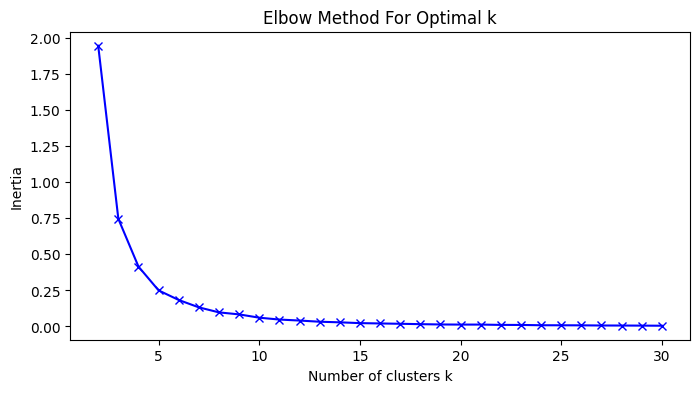

In [ ]:
def plot_elbow(embeddings, max_k=10):
    distortions = []
    K = range(2, max_k+1)
    for k in K:
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(embeddings)
        distortions.append(kmeans.inertia_)

    plt.figure(figsize=(8,4))
    plt.plot(K, distortions, 'bx-')
    plt.xlabel('Number of clusters k')
    plt.ylabel('Inertia')
    plt.title('Elbow Method For Optimal k')
    plt.show()

# Plot the elbow
plot_elbow(embeddings_reduced, max_k=30)

As the elbow plot shows, inertia decreases as k increases. However, around k=15, the rate of decrease slows significantly, making k=15 a reasonable choice for the number of clusters.

#K-means clustering

In [ ]:
# Using Scikit-learn's KMeans
k = 15  # Replace with your chosen number of clusters
kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)
unique_labs['KMeans_cluster'] = kmeans.fit_predict(embeddings_reduced)

In [ ]:
# Display the number of courses in each cluster
print(unique_labs['KMeans_cluster'].value_counts())

# View sample courses from each cluster
for cluster in range(k):
    print(f'\nCluster {cluster}:')
    print(unique_labs[unique_labs['KMeans_cluster'] == cluster]['description'].head(5))

KMeans_cluster
2     29
4     22
10    21
0     20
8     19
13    19
7     17
1     17
14    17
12    13
5     12
6     11
3      9
9      9
11     5
Name: count, dtype: int64

Cluster 0:
34     Classification Fundamentals for Marketing This...
271    Statistical Analysis and Visualization for Mar...
307    Classifying Cats & Dogs with HOG and SVM Class...
337    Building a Visual Search Engine Build a visual...
414    Identify Stop Signs with Transfer Learning In ...
Name: description, dtype: object

Cluster 1:
370    Deploy a Computer Vision App in a Serverless E...
421    Deploy your Serverless AI App in 10 Minutes wi...
725    Create a Simple Web Page with HTML in 10 minut...
857    Programming for Beginners: Hello World in 11 L...
963    Getting started with Linux Terminal Commands L...
Name: description, dtype: object

Cluster 2:
114    Great Expectations, a data validation library ...
308    Practicing Test Driven Development with Python...
363    Bring your Machine Learning mod

#Advanced Clustering with FAISS
FAISS is especially useful for handling large datasets.

In [ ]:
def faiss_kmeans_clustering(embeddings, num_clusters, num_iterations=100, nredo=1, gpu=False):
    d = embeddings.shape[1]  # Dimension of embeddings

    # Initialize FAISS KMeans
    kmeans = faiss.Kmeans(d=d, k=num_clusters, niter=num_iterations, nredo=nredo, verbose=True)

    if gpu and torch.cuda.is_available():
        # Move data and kmeans to GPU
        res = faiss.StandardGpuResources()
        kmeans = faiss.Kmeans(d=d, k=num_clusters, niter=num_iterations, nredo=nredo, verbose=True)
        kmeans.train(embeddings, faiss.GpuClonerOptions(res))
    else:
        kmeans.train(embeddings)

    # Assign clusters
    distances, assignments = kmeans.index.search(embeddings, 1)  # Search nearest cluster
    assignments = assignments.flatten()

    return assignments, kmeans

# Parameters
use_gpu = torch.cuda.is_available()  # Set to True if you want to use GPU

# Perform K-Means clustering using FAISS
assignments, kmeans = faiss_kmeans_clustering(embeddings_reduced, num_clusters=k, num_iterations=100, nredo=3, gpu=use_gpu)

# Assign clusters to the DataFrame
unique_labs['FAISS_cluster'] = assignments

### Agglomerative clustering


In [ ]:
clustering = AgglomerativeClustering(n_clusters=k)  # Adjust number of clusters as needed
unique_labs['Agg_cluster'] = clustering.fit_predict(embeddings_reduced)

In [ ]:
unique_labs.T.to_csv('labsClusters.csv')

#Evaluate clustering methods

The silhouette score is a measure used to evaluate the quality of clusters in a dataset. It assesses how well-separated and cohesive the clusters are. The score ranges from -1 to 1, with values closer to 1 indicating that clusters are well-defined and separate.

The silhouette score for a single data point is calculated based on two factors:

-	**Cohesion**: The average distance between the point and other points in its own cluster.
-	**Separation**: The average distance between the point and points in the nearest neighboring cluster.

The formula for the silhouette score of a data point  is:
$$Silhouette-score_i = \frac{b_i - a_i}{\max(a_i, b_i)}$$

where:
- $a_i$ is the average distance between point and other points in the same cluster.
- $b_i$ is the average distance between point and points in the closest cluster it is not part of.

The overall silhouette score is the average silhouette score across all data points, helping us determine if the chosen clustering model has created clear, distinct clusters:

•	A score close to 1: Clusters are well-defined and separated.
•	A score close to 0: Clusters overlap or are not well-separated.
•	A score below 0: Points may be incorrectly clustered.

This score is often used to compare clustering models and identify the optimal number of clusters in a dataset.


In [ ]:

# Calculate Silhouette Score for 'FAISS_cluster' column
silhouette_avg_cluster = silhouette_score(embeddings_reduced, unique_labs['KMeans_cluster'])
print(f"Silhouette Score for 'FAISS_cluster': {silhouette_avg_cluster}")

# Calculate Silhouette Score for 'FAISS_cluster' column
silhouette_avg_cluster2 = silhouette_score(embeddings_reduced, unique_labs['FAISS_cluster'])
print(f"Silhouette Score for 'FAISS_cluster': {silhouette_avg_cluster2}")

# Calculate Silhouette Score for 'AGG_cluster' column
silhouette_avg_cluster3 = silhouette_score(embeddings_reduced, unique_labs['Agg_cluster'])
print(f"Silhouette Score for 'AGG_cluster': {silhouette_avg_cluster3}")



Silhouette Score for 'FAISS_cluster': 0.6137161254882812
Silhouette Score for 'FAISS_cluster': 0.5661247968673706
Silhouette Score for 'AGG_cluster': 0.575290858745575


## Finding the best performing model
Create a function to create all possible combinations of Clustering method, DR method and the Embedding Transformer to check which one gives the best performance.

In [ ]:
# fit 3 different clustering methods using embeddings from all three models using the 2 dim reduction methods

def fit_clustering_methods(embeddings, k):
  """
  Args:
    embeddings: The embeddings to cluster.
    k: The number of clusters.

  Returns:
    A dictionary containing the cluster assignments for each method.
  """

  kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)
  cluster_kmeans = kmeans.fit_predict(embeddings)

  assignments, _ = faiss_kmeans_clustering(embeddings, num_clusters=k, num_iterations=100, nredo=3, gpu=False)
  cluster_faiss = assignments

  clustering = AgglomerativeClustering(n_clusters=k)
  cluster_agglomerative = clustering.fit_predict(embeddings)

  return {'kmeans': cluster_kmeans, 'faiss': cluster_faiss, 'agglomerative': cluster_agglomerative}

# Loop through all three models (BERT, RoBERTa, MiniLM)
for model_name in ['BERT', 'RoBERTa', 'MiniLM']:
  print(f"Clustering with model: {model_name}")

  # Load the appropriate model, tokenizer, and embedding function
  if model_name == 'BERT':
      model_name_used = 'bert-base-uncased'
  elif model_name == 'RoBERTa':
      model_name_used = 'roberta-base'
  else:  # MiniLM
      model_name_used = 'sentence-transformers/all-MiniLM-L6-v2'

  tokenizer = AutoTokenizer.from_pretrained(model_name_used)
  model = AutoModel.from_pretrained(model_name_used)
  model.to(device)
  model.eval()

  get_embeddings = get_mean_pooling_embeddings if AGG == 'MEAN' else CLS_embeddings
  embeddings = get_embeddings(descriptions, tokenizer, model, device)
  embeddings_scaled = scaler.fit_transform(embeddings)

  # Loop through both PCA and UMAP
  for DR in [True, False]:
    print(f"Dimensionality Reduction method: {'PCA' if DR else 'UMAP'}")
    if DR:
      embeddings_reduced = pca.fit_transform(embeddings_scaled)
    else:
      embeddings_reduced = reducer.fit_transform(embeddings_scaled)

    embeddings_reduced = normalize(embeddings_reduced)

    # Fit the clustering methods
    cluster_assignments = fit_clustering_methods(embeddings_reduced, k)


    # Print some results or metrics (e.g., Silhouette score)
    for method, clusters in cluster_assignments.items():
      silhouette_avg = silhouette_score(embeddings_reduced, clusters)
      print(f"Silhouette Score for {method}: {silhouette_avg}")



Clustering with model: BERT


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Dimensionality Reduction method: PCA
Silhouette Score for kmeans: 0.20207543821292367
Silhouette Score for faiss: 0.18803530698918855
Silhouette Score for agglomerative: 0.2066526211808847
Dimensionality Reduction method: UMAP
Silhouette Score for kmeans: 0.5721597671508789
Silhouette Score for faiss: 0.5432522892951965
Silhouette Score for agglomerative: 0.5535498857498169
Clustering with model: RoBERTa


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Dimensionality Reduction method: PCA
Silhouette Score for kmeans: 0.24387935723097026
Silhouette Score for faiss: 0.22484930168130085
Silhouette Score for agglomerative: 0.21981020044036487
Dimensionality Reduction method: UMAP
Silhouette Score for kmeans: 0.5734462141990662
Silhouette Score for faiss: 0.5777987837791443
Silhouette Score for agglomerative: 0.5501800775527954
Clustering with model: MiniLM


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Dimensionality Reduction method: PCA
Silhouette Score for kmeans: 0.308676448235773
Silhouette Score for faiss: 0.2778270877475044
Silhouette Score for agglomerative: 0.28977023732138163
Dimensionality Reduction method: UMAP
Silhouette Score for kmeans: 0.5823267102241516
Silhouette Score for faiss: 0.5509673953056335
Silhouette Score for agglomerative: 0.5633938312530518
